# Advanced: Emcee Sampler

## Setup

Let's first make sure we have the latest version of PHOEBE 2.3 installed (uncomment this line if running in an online notebook session such as colab).

In [1]:
#!pip install -I "phoebe>=2.3,<2.4"

In [2]:
import phoebe
from phoebe import u # units
import numpy as np

logger = phoebe.logger('error')

## Create fake "observations"

We'll create the same fake "observations" as in the [Inverse Paper Examples](../examples/inverse_paper_examples.ipynb).

For the sake of efficiency for this example, we'll use the ellc backend.  In practice, this is only safe for areas of the parameter space where [phoebe](../api/phoebe.parameters.compute.phoebe.md) and [ellc](../api/phoebe.parameters.compute.ellc.md) are in sufficient agreement.

In [3]:
b = phoebe.default_binary()
b.set_value('ecc', 0.2)
b.set_value('per0', 25)
b.set_value('teff@primary', 7000)
b.set_value('teff@secondary', 6000)
b.set_value('sma@binary', 7)
b.set_value('incl@binary', 80)
b.set_value('q', 0.3)
b.set_value('t0_supconj', 0.1)
b.set_value('requiv@primary', 2.0)
b.set_value('vgamma', 80)

lctimes = phoebe.linspace(0, 10, 1005)
rvtimes = phoebe.linspace(0, 10, 105)
b.add_dataset('lc', compute_times=lctimes)
b.add_dataset('rv', compute_times=rvtimes)

b.add_compute('ellc', compute='fastcompute')
b.set_value_all('ld_mode', 'lookup')
b.run_compute(compute='fastcompute')

fluxes = b.get_value('fluxes@model') + np.random.normal(size=lctimes.shape) * 0.01
fsigmas = np.ones_like(lctimes) * 0.02

rvsA = b.get_value('rvs@primary@model') + np.random.normal(size=rvtimes.shape) * 10
rvsB = b.get_value('rvs@secondary@model') + np.random.normal(size=rvtimes.shape) * 10
rvsigmas = np.ones_like(rvtimes) * 20

100%|██████████| 3/3 [00:00<00:00, 47.08it/s]


In [4]:
b = phoebe.default_binary()

b.add_dataset('lc', 
              compute_phases=phoebe.linspace(0,1,201),
              times=lctimes, 
              fluxes=fluxes, 
              sigmas=fsigmas, 
              dataset='lc01')

b.add_dataset('rv', 
              compute_phases=phoebe.linspace(0,1,201),
              times=rvtimes, 
              rvs={'primary': rvsA, 'secondary': rvsB}, 
              sigmas=rvsigmas, 
              dataset='rv01')

b.add_compute('ellc', compute='fastcompute')
b.set_value_all('ld_mode', 'lookup')

We'll set the initial model to be *very close* to the correct values, but not exact.  In practice, we would instead have to use a combination of manual tweaking, [LC estimators](./LC_estimators.ipynb), and [RV_estimators](./RV_estimators.ipynb), and [optimizers](./nelder_mead.ipynb) to get essentially our final solution *before* using a sampler to probe the local parameter space and estimate parameter uncertainties (emcee can "burnin" to the solution, but this is inefficient and can get stuck from finding the actual solution).

In [5]:
b.set_value('ecc', 0.2)
b.set_value('per0', 25)
b.set_value('teff@primary', 7000)
b.set_value('teff@secondary', 6000)
b.set_value('sma@binary', 7+0.01)
b.set_value('incl@binary', 80+0.1)
b.set_value('q', 0.3)
b.set_value('t0_supconj', 0.1-0.001)
b.set_value('requiv@primary', 2.0-0.05)
b.set_value('vgamma', 80)

In [6]:
b.run_compute(compute='fastcompute', model='orig_model')

100%|██████████| 3/3 [00:00<00:00, 92.12it/s]


<ParameterSet: 7 parameters | kinds: rv, lc>

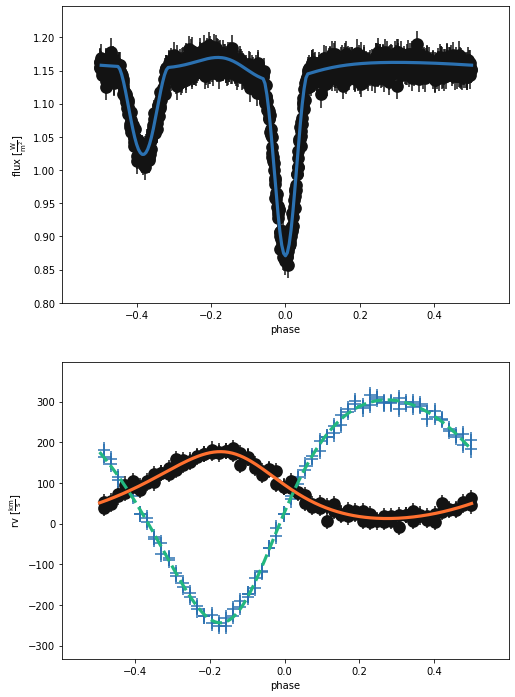

In [7]:
_ = b.plot(x='phases', show=True)

Its always a good idea to check the residuals before moving on to sampling to make sure that there are no significant phase-dependent systematics.

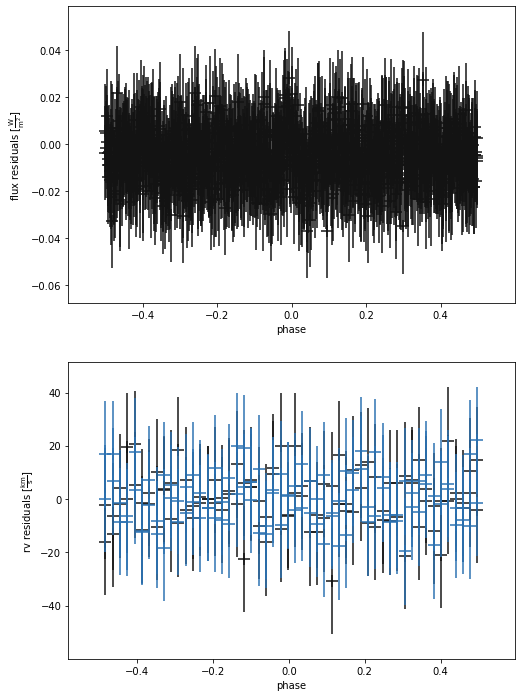

In [8]:
_ = b.plot(x='phases', y='residuals', show=True)

## Emcee Options

As with any solver, we call [b.add_solver](../api/phoebe.frontend.bundle.Bundle.add_solver.md) and this time pass [sampler.emcee](../api/phoebe.parameters.solver.sampler.emcee.md).

In [9]:
b.add_solver('sampler.emcee', solver='emcee_solver')

<ParameterSet: 13 parameters | qualifiers: comments, burnin_factor, init_from_combine, init_from, continue_from, progress_every_niters, niters, expose_failed, thin_factor, compute, priors, priors_combine, nwalkers>

This adds new parameters to our bundle with the options for running emcee.

In [10]:
print(b.filter(solver='emcee_solver'))

ParameterSet: 11 parameters
     comments@emcee_solver@solver: 
      compute@emcee_solver@solver: phoebe01
   continue_from@emcee_solver@...: None
    init_from@emcee_solver@solver: []
       priors@emcee_solver@solver: []
     nwalkers@emcee_solver@solver: 16
       niters@emcee_solver@solver: 100
   burnin_factor@emcee_solver@...: 2.0
   thin_factor@emcee_solver@so...: 0.5
   progress_every_niters@emcee...: 0
   expose_failed@emcee_solver@...: True


Here we get to choose which set of compute-options will be used while sampling (we'll choose the ellc compute options we called 'fastcompute' just for the sake of efficiency)

In [11]:
b.set_value('compute', solver='emcee_solver', value='fastcompute')

### Initializing Distributions

Instead of the `fit_parameters` list that was used for [optimizers](./nelder_mead.ipynb), emcee requires initializing distributions.  Each of our `nwalkers` walkers will then draw from this distribution set to determine the starting position in parameter space.

For this case, we'll sample over just a few parameters (the ones that we offset somewhat from the known true solution).  In practice, you want to sample over as many of the most-sensitive parameters as possible to account for any correlations between the parameters... but each additional parameter adds a dimension to the parameter space that needs to be sampled and so increases the computational cost.

If using `pblum_mode='dataset-scaled'` while optimizing, it is generally a good idea to disable this (set to 'component-coupled' or 'dataset-coupled' and sample over `pblum` to account for any correlations between the luminosities and your other sampled parameters.  For more details, see the [pblum tutorial](./pblum.ipynb).

If your observational uncertainties are not reliable, you may also want to sample over `sigmas_lnf` (the [emcee fitting a line tutorial](https://emcee.readthedocs.io/en/stable/tutorials/line/) has a nice overview on the mathematics, and the [inverse paper](http://phoebe-project.org/publications/2020Conroy+) describes the implementation within PHOEBE).

See the [distributions tutorial](./distributions.ipynb) for more details on adding distributions.

In [12]:
b.add_distribution({'sma@binary': phoebe.gaussian_around(0.1),
                    'incl@binary': phoebe.gaussian_around(5),
                    't0_supconj': phoebe.gaussian_around(0.001),
                    'requiv@primary': phoebe.gaussian_around(0.2),
                    'pblum@primary': phoebe.gaussian_around(0.2),
                    'sigmas_lnf@lc01': phoebe.uniform(-1e9, -1e4),
                   }, distribution='ball_around_guess')

<ParameterSet: 6 parameters | components: binary, primary>

It is useful to make sure that the model-parameter space represented by this initializing distribution covers the observations themselves.

In [13]:
b.run_compute(compute='fastcompute', sample_from='ball_around_guess', 
              sample_num=20, model='init_from_model')

100%|██████████| 3/3 [00:00<00:00, 110.99it/s]


<ParameterSet: 12 parameters | kinds: rv, lc>

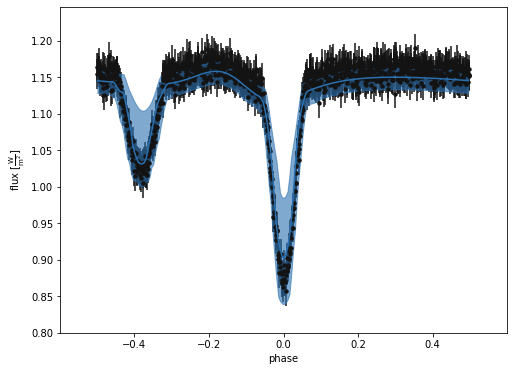

In [14]:
_ = b.plot(dataset='lc01', x='phases', 
           marker={'dataset': '.'},
           model='init_from_model', show=True)

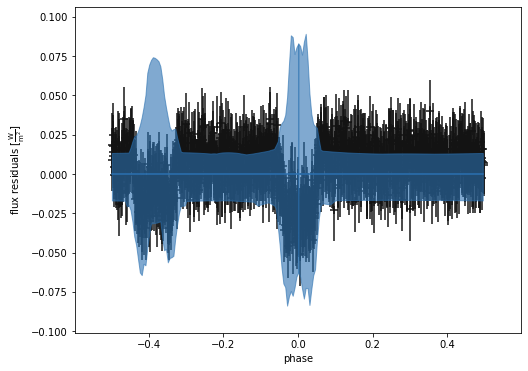

In [15]:
_ = b.plot(dataset='lc01', x='phases', y='residuals',
           z={'dataset': 0, 'model': 1},
           model='init_from_model', show=True)

Creating distributions alone does *nothing*.  In order to use this distribution set as our initializing distribution within emcee, we need to set `init_from` in the solver options.

In [16]:
b.set_value('init_from', 'ball_around_guess')

### Prior Distributions

Optionally, you can also set the priors to be used within MCMC.  Generally, you only want to include priors if you know something in advance (perhaps a reliable constraint on asini from the literature) that is not included in your observations.  But priors can also be used to prevent the walkers from wandering into a region of the parameter space (you should however disclose the priors you use in the publication of any results).

To add priors, you would do the same as above by creating a distribution set and then setting the `priors` parameter in the emcee solver options.

### nwalkers, niters

We also need to set options for the number of walkers (`nwalkers`) and number of iterations (`niters`).  You must set `nwalkers` to at least double the number of parameters you've defined in the initializing distribution (`2*6=12` in this case).  Since running emcee will be done in parallel (using either multiprocessing or mpi) within each iteration, it makes sense to also set this as a multiple of the number of processors available.

If using MPI, parallelization will occur per walker (with run_compute serialized) if `nwalkers <= nprocs`, otherwise emcee will be serialized and `run_compute`.

In [17]:
b.set_value('nwalkers', solver='emcee_solver', value=12)

We need to run enough iterations so that the chains converge (see [emcee's tutorial on convergence](https://emcee.readthedocs.io/en/stable/tutorials/autocorr/)).  It is difficult to estimate the number of iterations necessary in advance, but have no fear: you can always [continue emcee from a previous run](./emcee_continue_from.ipynb) or [run emcee externally and monitor its progress](./export_solver.ipynb).

For this example, we'll set `niters` to be quite small so that it can complete with a notebook (and ignore whether it is actually fully converged or not).

In [18]:
b.set_value('niters', solver='emcee_solver', value=250)

## Running Emcee

Once our options are set, we can call [b.run_solver](../api/phoebe.frontend.bundle.Bundle.run_solver.md), pass the label of our solver ('emcee_solver' in this case), and optionally a label for the resulting "solution" (same as labeling the results from [b.run_compute](../api/phoebe.frontend.bundle.Bundle.run_compute.md) with a "model").

In this case, we want to sample **only** the LCs, so we'll disable the RVs in the compute options that we're using.

In [19]:
print(b.filter(qualifier='enabled', compute='fastcompute'))

ParameterSet: 2 parameters
   enabled@lc01@fastcompute@co...: True
   enabled@rv01@fastcompute@co...: True


In [20]:
b.disable_dataset('rv01', compute='fastcompute')

<ParameterSet: 24 parameters | components: binary, secondary, primary>

In [21]:
print(b.filter(qualifier='enabled', compute='fastcompute'))

ParameterSet: 2 parameters
   enabled@lc01@fastcompute@co...: True
   enabled@rv01@fastcompute@co...: False


We're only running with a small number of walkers and iterations, and with an efficient backend.  In practice, running emcee can take a significant amount of computing resources and time, and therefore you'll likely want to run on a high-performance cluster (HPC).  You could of course run your entire script there, but working interactively on these machines is not always convenient.  Instead, you may want to *prepare* your emcee run locally, call [b.export_solver](../api/phoebe.frontend.bundle.Bundle.export_solver.md) and then [b.import_solution](../api/phoebe.frontend.bundle.Bundle.import_solution.md) on the resulting file.  For more details and discussion, see [Advanced: Running Solvers on an External Machine](./export_solver.ipynb).

In [22]:
b.run_solver('emcee_solver', solution='emcee_sol')

  0%|          | 1/250 [00:03<14:16,  3.44s/it]/home/kyle/.local/lib/python3.8/site-packages/phoebe/parameters/parameters.py:3729: RuntimeWarning: overflow encountered in exp
  sigmas2 += model_interp.value ** 2 * np.exp(2 * sigmas_lnf)
/home/kyle/.local/lib/python3.8/site-packages/phoebe/parameters/parameters.py:3729: RuntimeWarning: overflow encountered in exp
  sigmas2 += model_interp.value ** 2 * np.exp(2 * sigmas_lnf)
/home/kyle/.local/lib/python3.8/site-packages/phoebe/parameters/parameters.py:3729: RuntimeWarning: overflow encountered in exp
  sigmas2 += model_interp.value ** 2 * np.exp(2 * sigmas_lnf)
  2%|▏         | 5/250 [00:14<12:01,  2.95s/it]/home/kyle/.local/lib/python3.8/site-packages/phoebe/parameters/parameters.py:3729: RuntimeWarning: overflow encountered in exp
  sigmas2 += model_interp.value ** 2 * np.exp(2 * sigmas_lnf)
 14%|█▍        | 35/250 [01:33<09:36,  2.68s/it]/home/kyle/.local/lib/python3.8/site-packages/phoebe/parameters/parameters.py:3729: RuntimeWarning

<ParameterSet: 20 parameters | qualifiers: fitted_twigs, thin, distributions_convert, progress, comments, lnprobabilities, fitted_uniqueids, burnin, adopt_distributions, adopt_values, failed_samples, samples, acceptance_fractions, adopt_parameters, autocorr_times, nwalkers, fitted_units, niters, lnprob_cutoff, wrap_central_values>

## Returned Solution

Once `run_solver` is complete (or after calling `import_solution`) a number of new parameters have been added.  Let's now look at some of these new parameters.

In [24]:
print(b.filter(solution='emcee_sol').twigs)

['wrap_central_values@fastcompute@emcee_solver@emcee_sol@emcee@solution', 'fitted_uniqueids@fastcompute@emcee_solver@emcee_sol@emcee@solution', 'fitted_twigs@fastcompute@emcee_solver@emcee_sol@emcee@solution', 'fitted_units@fastcompute@emcee_solver@emcee_sol@emcee@solution', 'adopt_parameters@fastcompute@emcee_solver@emcee_sol@emcee@solution', 'adopt_distributions@fastcompute@emcee_solver@emcee_sol@emcee@solution', 'distributions_convert@fastcompute@emcee_solver@emcee_sol@emcee@solution', 'adopt_values@fastcompute@emcee_solver@emcee_sol@emcee@solution', 'niters@fastcompute@emcee_solver@emcee_sol@emcee@solution', 'nwalkers@fastcompute@emcee_solver@emcee_sol@emcee@solution', 'samples@fastcompute@emcee_solver@emcee_sol@emcee@solution', 'failed_samples@fastcompute@emcee_solver@emcee_sol@emcee@solution', 'lnprobabilities@fastcompute@emcee_solver@emcee_sol@emcee@solution', 'acceptance_fractions@fastcompute@emcee_solver@emcee_sol@emcee@solution', 'autocorr_times@fastcompute@emcee_solver@emcee

## adopt_parameters

As was the case in the [Nelder-Mead optimizer](./nelder_mead.ipynb), the emcee solution contains an `adopt_parameters` parameter which dictates if a subset of the sampled parameters should be adopted.  By default, this is set to all of the sampled parameters.

In [25]:
print(b.get_parameter('adopt_parameters', solution='emcee_sol'))

Parameter: adopt_parameters@emcee_sol@solution
                       Qualifier: adopt_parameters
                     Description: which of the parameters should be included when adopting (and plotting) the solution
                           Value: ['sma@binary@orbit@component', 'incl@binary@orbit@component', 't0_supconj@binary@orbit@component', 'requiv@primary@star@component', 'pblum@primary@lc01@lc@dataset', 'sigmas_lnf@lc01@lc@dataset']
                         Choices: sma@binary@orbit@component, incl@binary@orbit@component, t0_supconj@binary@orbit@component, requiv@primary@star@component, pblum@primary@lc01@lc@dataset, sigmas_lnf@lc01@lc@dataset
                  Constrained by: 
                      Constrains: None
                      Related to: None



Changing this parameter (or passing as a kwarg to temporarily override) to a subset would affect the plotting, propagating, and adopt_solution that is discussed below.

## burnin, thin, lnprob_cutoff

PHOEBE attempts to estimate the value that should be used for the `burnin` (number of iterations at the start of the MCMC run to be discarded), `thin` (only take every `thin` iterations after burnin has been discarded), and `lnprob_cutoff` (discard all samples with a log-probability *worse* than a prescribed value - useful for "cropping" out stuck branches and [resampling](./emcee_resampling.ipynb)).

By default, these are estimated based on the `burnin_factor` and `thin_factor` in the solver options.

In [26]:
print(b.get_parameter('burnin_factor', solver='emcee_solver'))

Parameter: burnin_factor@emcee_solver@solver
                       Qualifier: burnin_factor
                     Description: factor of max(autocorr_times) to apply for burnin (burnin not applied until adopting the solution)
                           Value: 2.0
                  Constrained by: 
                      Constrains: None
                      Related to: None



In [27]:
print(b.get_parameter(qualifier='thin_factor', solver='emcee_solver'))

Parameter: thin_factor@emcee_solver@solver
                       Qualifier: thin_factor
                     Description: factor of min(autocorr_times) to apply for thinning (thinning not applied until adopting the solution)
                           Value: 0.5
                  Constrained by: 
                      Constrains: None
                      Related to: None



In [28]:
print(b.filter(qualifier=['burnin', 'thin', 'lnprob_cutoff', 'autocorr_times']))

ParameterSet: 4 parameters
R  autocorr_times@emcee_sol@so...: [25.3295078  21.788571   28.64826194 18.46371331 20.18362692 24.71533851]
        burnin@emcee_sol@solution: 57
          thin@emcee_sol@solution: 9
   lnprob_cutoff@emcee_sol@sol...: -inf


Changing these values (or passing overrides as kwargs) would also affect the plotting, propagating, and adopt_solution that is discussed below.

### distributions_convert

The `distributions_convert` parameter dictates whether the distributions should internally be stored as the full underlying parameter samples (most *fair* representation of the posterior distributions, but also expensive to store) or on converted to another distribution type.

Converting to a multivariate gaussian ("mvgaussian"), for example, results in a very lightweight distribution object that can then easily be used for a future initializing or prior distribution.  However, it is important to manually check that the original distribution is well-represented by a multivariate gaussian first. **WITH GREAT POWER COMES GREAT RESPONSIBILITY!!**

Examples of this in action can be seen in [Advanced: convert posterior distributions from EMCEE](./emcee_distributions_convert.ipynb).

In [29]:
print(b.get_parameter('distributions_convert', solution='emcee_sol'))

Parameter: distributions_convert@emcee_sol@solution
                       Qualifier: distributions_convert
                     Description: type of distribution to use when calling adopt_solution, get_distribution_collection, or plot. mvsamples: chains are stored directly and used for sampling with a KDE generated on-the-fly to compute probabilities.  mvhistogram: chains are binned according to distributions_bins and stored as an n-dimensional histogram.  mvgaussian: a multivariate gaussian is fitted to the samples, use only if distribution is sufficiently represented by gaussians.  samples: a univariate representation of mvsamples.  histogram: a univariate representation of mvhistogram.  gaussian: a univariate representation of mvgaussian.
                           Value: mvsamples
                         Choices: mvsamples, mvhistogram, mvgaussian, samples, histogram, gaussian
                  Constrained by: 
                      Constrains: None
                      Related 

Changing this parameter (or passing overrides as kwargs) would also affect the plotting, propagating, and adopt_solution that is discussed below.

# Plotting the Solution

There are multiple plot "styles" that can be plotted from the emcee solution.  These include:

* 'lnprobability' (plot of lnprobability vs iteration per-walker)
* 'corner' (corner plot of the posteriors)
* 'failed' (corner plot including location of failed samples)
* 'trace' (value of each parameter vs iteration per-walker)

Note that for each of these, the values for `adopt_parameters`, `burnin`, `thin`, and `lnprob_cutoff` are taken from the parameters in the solution if not overridden as a keyword argument.

It is usually a good idea to confirm that the values for `burnin` and `thin` are appropriate by plotting the lnprobability vs iteration.

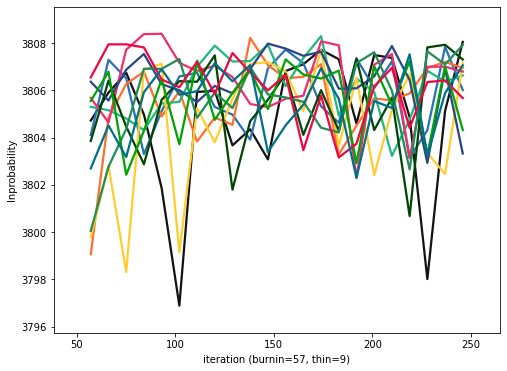

In [30]:
_ = b.plot(solution='emcee_sol', style='lnprobability', show=True)

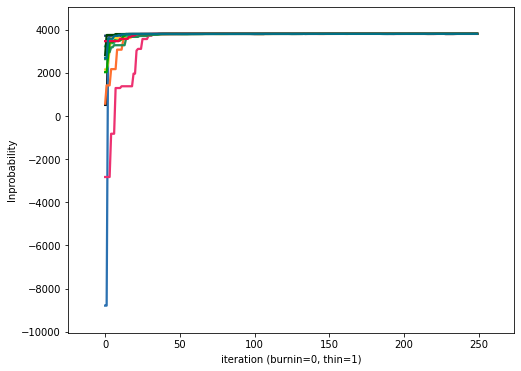

In [31]:
_ = b.plot(solution='emcee_sol', style='lnprobability', burnin=0, thin=1, show=True)

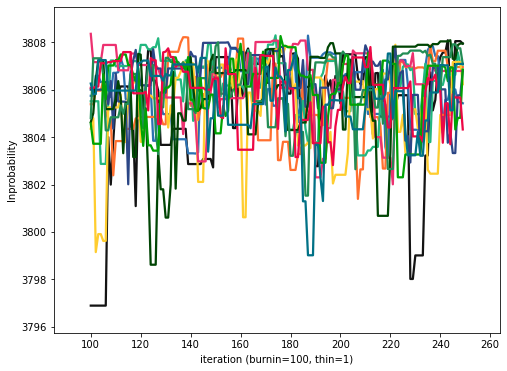

In [32]:
_ = b.plot(solution='emcee_sol', style='lnprobability', burnin=100, thin=1, show=True)

In [33]:
b.set_value('burnin', 50)
b.set_value('thin', 1)

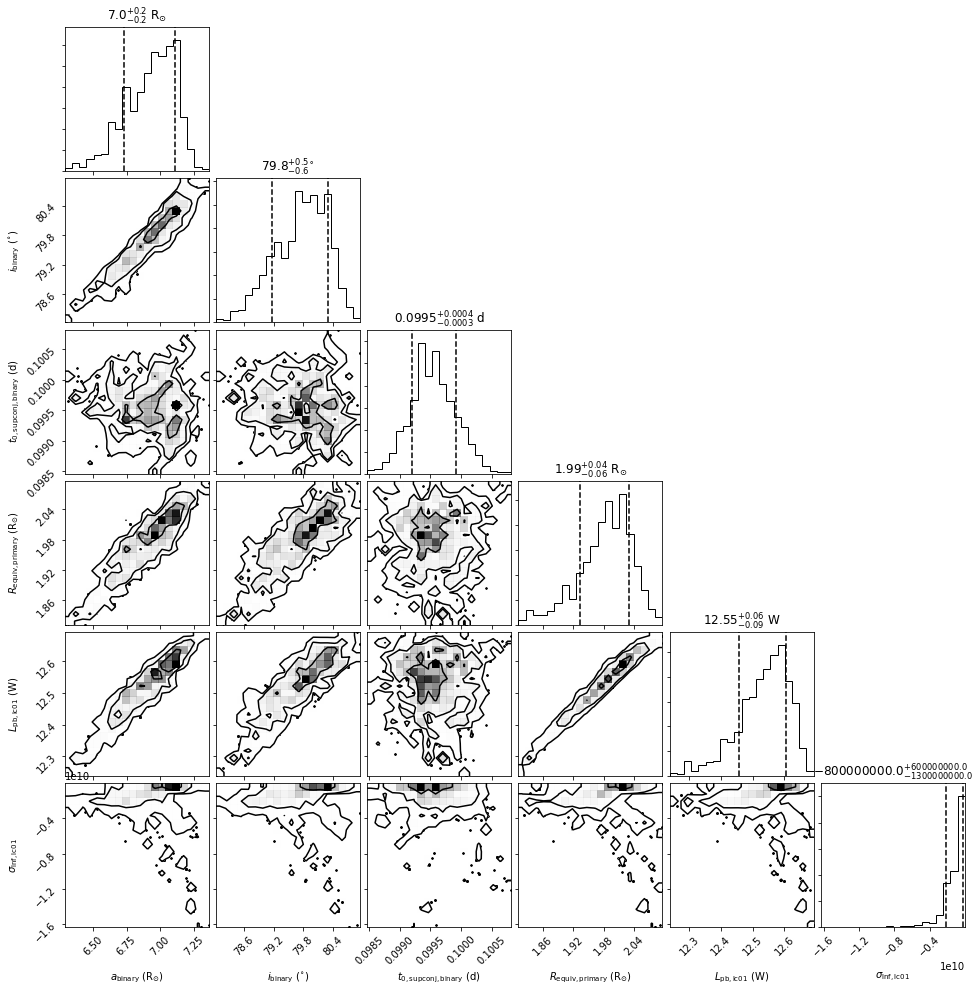

In [34]:
_ = b.plot(solution='emcee_sol', style='corner', show=True)

To change the latex representation of these parameter labels, see [Advanced: latex representation](./latex_repr.ipynb)

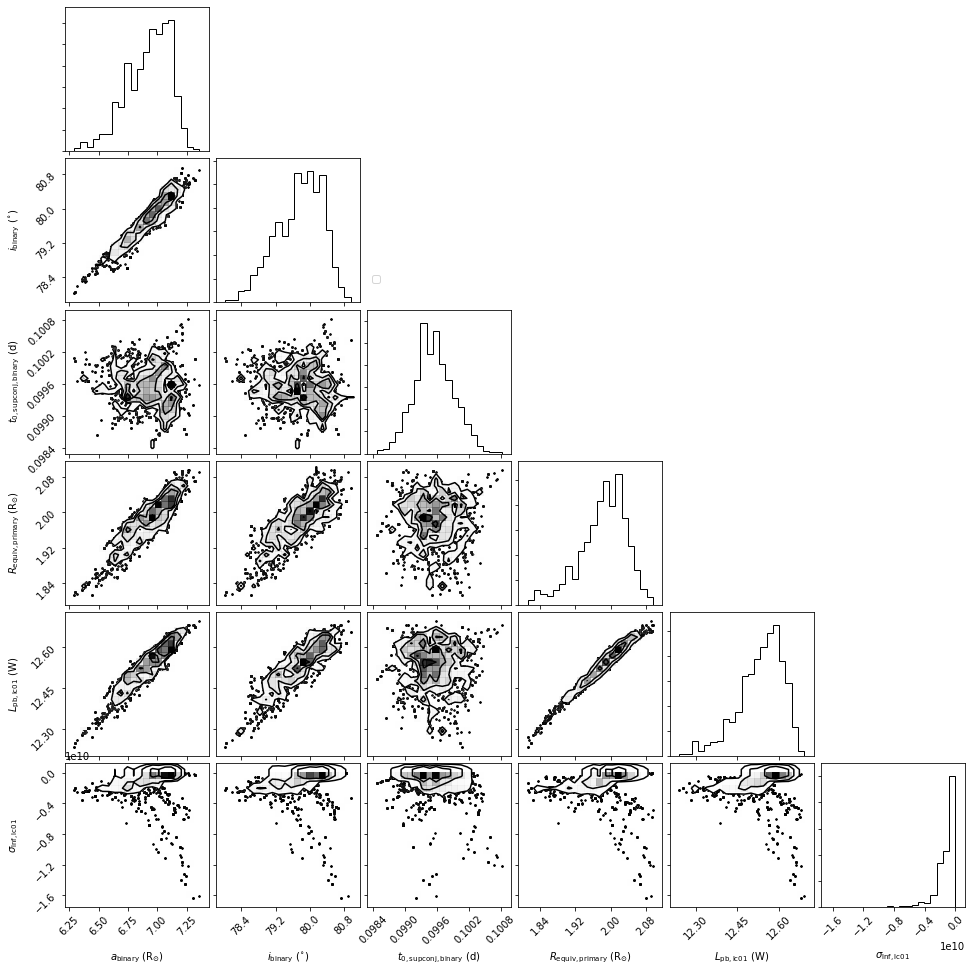

In [35]:
_ = b.plot(solution='emcee_sol', style='failed', show=True)

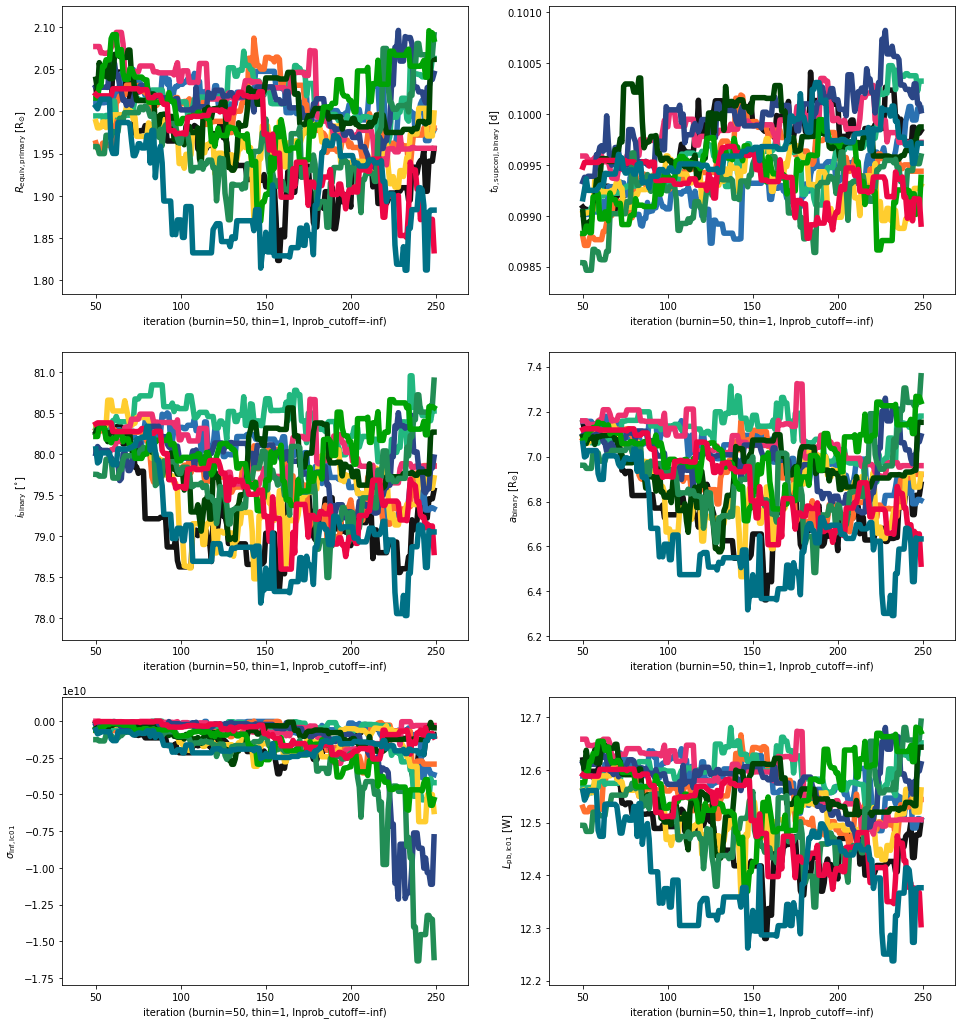

In [36]:
_ = b.plot(solution='emcee_sol', style='trace', show=True)

## Propagating through Forward-Model

To see how the posteriors (represented by the corner plot) are represented as propagated through the forward model, we can pass the solution to `sample_from` when calling `b.run_compute` (as we did earlier for the priors).

This is again important - we want posteriors that are representative of the spread (and uncertainties) in our observations.  **NOTE**: for the sake of this tutorial we ran an extremely limited number of iterations and did not check for convergence and therefore our posteriors are likely unreliable.

In [37]:
b.run_compute(compute='fastcompute', sample_from='emcee_sol', 
              sample_num=20, model='emcee_sol_model')

100%|██████████| 1/1 [00:00<00:00, 63.63it/s]


<ParameterSet: 8 parameters | qualifiers: comments, sample_mode, times, failed_samples, sampled_uniqueids, fluxes, sampled_twigs, samples>

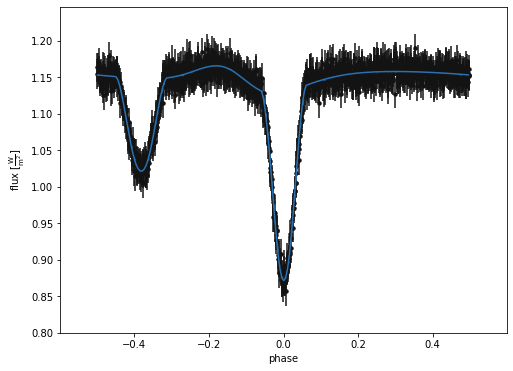

In [38]:
_ = b.plot(dataset='lc01', x='phases', 
           marker={'dataset': '.'},
           model='emcee_sol_model', show=True)

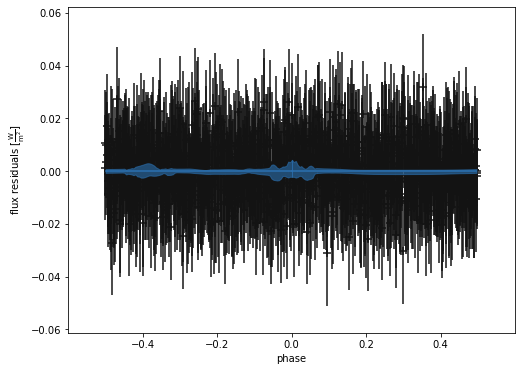

In [39]:
_ = b.plot(dataset='lc01', x='phases', y='residuals',
           z={'dataset': 0, 'model': 1},
           model='emcee_sol_model', show=True)

## Adopting the Solution

When calling [adopt_solution](../api/phoebe.frontend.bundle.Bundle.adopt_solution.md), we can decide whether we want to adopt the posterior distributions (given `burnin`, `thin`, `lnprob_cutoff`, and `distributions_convert`) as a distribution and/or the median values of each parameter as their face-values.  By default, both will be adopted, but this behavior can be changed by changing the values of the `adopt_values`/`adopt_distributions` parameters in the solution or overriding as keyword arguments to [adopt_solution](../api/phoebe.frontend.bundle.Bundle.adopt_solution.md).

If `adopt_distributions` is True, then you can also optionally pass the `distribution` label to `adopt_solution`.

In [40]:
print(b.get_parameter('adopt_values', solution='emcee_sol'))

Parameter: adopt_values@emcee_sol@solution
                       Qualifier: adopt_values
                     Description: whether to update the parameter face-values (of the means of all parameters in adopt_parameters) when calling adopt_solution.
                           Value: True
                  Constrained by: 
                      Constrains: None
                      Related to: None



In [41]:
print(b.get_parameter('adopt_distributions', solution='emcee_sol'))

Parameter: adopt_distributions@emcee_sol@solution
                       Qualifier: adopt_distributions
                     Description: whether to create a distribution (of all parameters in adopt_parameters according to distributions_convert) when calling adopt_solution.
                           Value: True
                  Constrained by: 
                      Constrains: None
                      Related to: None



As always, you can always pass `trial_run=True` to `adopt_solution` to see what *would* happen.

In [42]:
print(b.adopt_solution(solution='emcee_sol', trial_run=True))

ParameterSet: 12 parameters
         sma@dists02@distribution: <distl.mvsamplesslice dimension=0 samples=[[ 7.15168747e+00  8.02629767e+01  9.90851430e-02  2.02854433e+00
   1.26189339e+01 -1.27199644e+08]
 [ 7.15654998e+00  8.03399431e+01  9.90133330e-02  2.01032325e+00
   1.25883610e+01 -1.76984469e+08]
 [ 7.07497371e+00  8.02986974e+01  9.87952962e-02  1.96272573e+00
   1.25291228e+01 -6.42943044e+08]
 ...
 [ 7.24406209e+00  8.05633837e+01  9.93773171e-02  2.08544425e+00
   1.26720328e+01 -5.34400482e+09]
 [ 6.52122362e+00  7.87978215e+01  9.89177725e-02  1.83471187e+00
   1.23060634e+01 -1.07814580e+09]
 [ 6.63361726e+00  7.90481330e+01  9.97118670e-02  1.88291727e+00
   1.23762303e+01 -1.03411095e+09]] weights=None bw_method=None unit=solRad label=sma@binary)>
        incl@dists02@distribution: <distl.mvsamplesslice dimension=1 samples=[[ 7.15168747e+00  8.02629767e+01  9.90851430e-02  2.02854433e+00
   1.26189339e+01 -1.27199644e+08]
 [ 7.15654998e+00  8.03399431e+01  9.90133330e

In [43]:
b.adopt_solution(solution='emcee_sol', distribution='emcee_posteriors')

<ParameterSet: 30 parameters | contexts: dataset, distribution, component>

## Posteriors and Uncertainties

Now that we have adopted our (processed) chains as a distribution object within PHOEBE, we can use these distribution objects to:
* [re-initialize another emcee run](./emcee_resample.ipynb)
* propage through the forward model (`b.run_compute(sample_from='emcee_posteriors', sample_num=20)`)
* use as priors in any optimizer or sampler
* estimate n-sigma uncertainties

In [44]:
print(b.filter(distribution='emcee_posteriors').twigs)

['sma@binary@emcee_posteriors@distribution', 'incl@binary@emcee_posteriors@distribution', 't0_supconj@binary@emcee_posteriors@distribution', 'requiv@primary@emcee_posteriors@distribution', 'pblum@primary@lc01@emcee_posteriors@distribution', 'sigmas_lnf@lc01@emcee_posteriors@distribution']


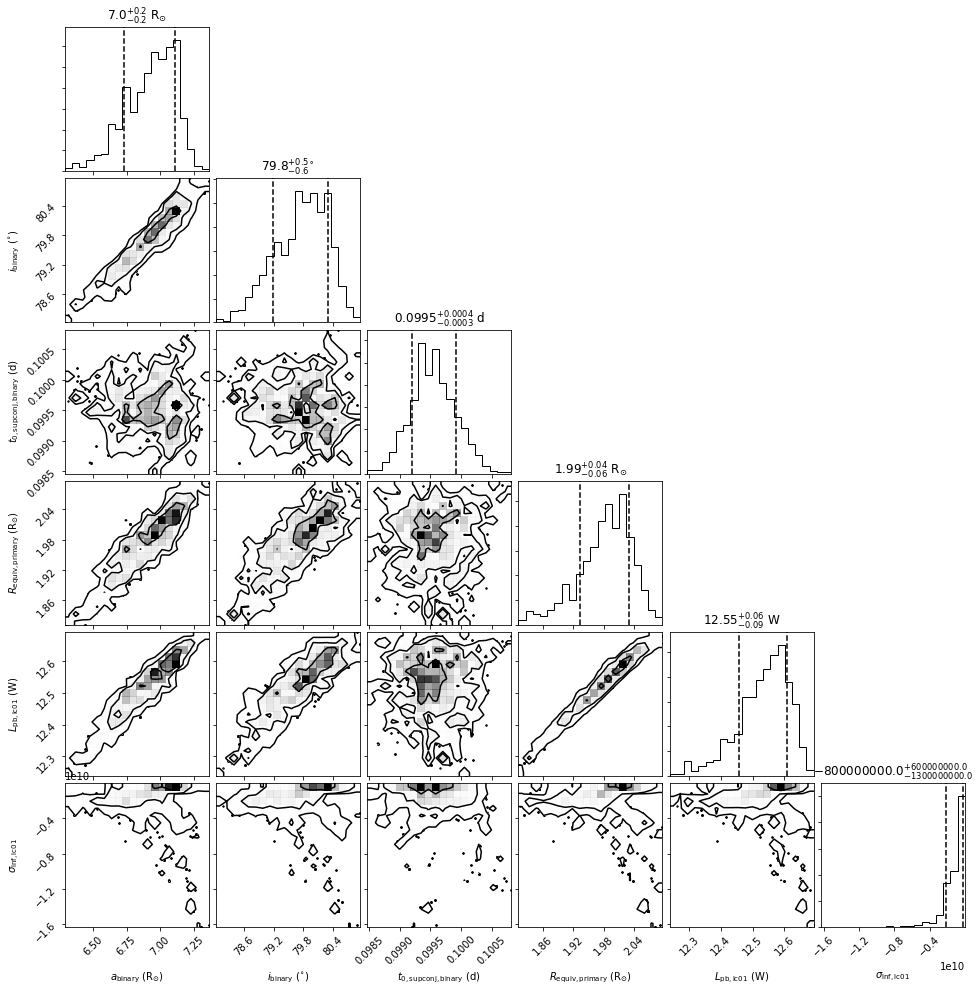

In [45]:
_ = b.plot_distribution_collection(distribution='emcee_posteriors', show=True)

To estimate 1-D n-sigma uncertainties from any distribution collection (in this case our posteriors), call [b.uncertainties_from_distribution_collection](../api/phoebe.frontend.bundle.Bundle.uncertainties_from_distribution_collection.md).

In [46]:
b.uncertainties_from_distribution_collection(distribution='emcee_posteriors', sigma=3, tex=True)

sma@binary = 7.0 +0.4 -0.7  solRad
 incl@binary = 80.0 +1.0 -2.0  deg
 t0_supconj@binary = 0.1 +0.001 -0.001  d
 requiv@primary = 2.0 +0.1 -0.2  solRad
 pblum@lc01 = 12.5 +0.1 -0.3  W
 sigmas_lnf@lc01 = -800000000.0 +800000000.0 -13700000000.0  

See [Advanced: latex representation](./latex_repr.ipynb) to change the latex representation of the parameter names.

For an ascii-friendly representation of the lower- middle- and upper- bounds of these uncertainties, use `tex=False`

In [47]:
b.uncertainties_from_distribution_collection(distribution='emcee_posteriors', sigma=3, tex=False)

[array([6.30244658, 6.95854179, 7.322526  ]),
 array([78.05247555, 79.82254753, 80.84147822]),
 array([0.09848241, 0.09953063, 0.10064651]),
 array([1.81241887, 1.98970968, 2.09375522]),
 array([12.2502618 , 12.54668835, 12.68046992]),
 array([-1.45393646e+10, -8.20896250e+08, -2.49076210e+06])]

## See Also

See the following for even more advanced use cases of emcee.  For these, we'll pickup with the bundle from here, so we'll save it to disk first so we don't have to repeat all these steps.

* [Advanced: continuing emcee from a previous run](./emcee_continue_from.ipynb)
* [Advanced: resampling emcee from a previous run](./emcee_resample.ipynb)
* [Advanced: convert posterior distributions from EMCEE](./emcee_distributions_convert.ipynb)

In [48]:
b.save('emcee_advanced_tutorials.bundle')

'emcee_advanced_tutorials.bundle'